## Imports

In [1]:
import pandas as pd
import polars as pl
from stratmanager import StrategyManager

import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt 

### Data Extraction and Returns Overview

In [8]:
# Extract Data
start_date = "2017-01-01"
end_date = "2024-07-20"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df_copy()
df.head()

[*********************100%%**********************]  1 of 1 completed


date,open,high,low,close,adj_close,volume,returns,range,Bench_C_Rets
datetime[ns],f64,f64,f64,f64,f64,i64,f64,f64,f64
2017-01-02 00:00:00,998.617004,1031.390015,996.702026,1021.75,1021.75,222184992,0.023464,0.034803,0.000146
2017-01-03 00:00:00,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,0.02162,0.022005,0.000682
2017-01-04 00:00:00,1044.400024,1159.420044,1044.400024,1154.72998,1154.72998,344945984,0.106233,0.11013,0.002415
2017-01-05 00:00:00,1156.72998,1191.099976,910.416992,1013.380005,1013.380005,510199008,-0.12241,0.308302,0.003266
2017-01-06 00:00:00,1014.23999,1046.810059,883.94397,902.200989,902.200989,351876000,-0.109711,0.184249,0.004696


In [7]:
print(df.schema)

OrderedDict({'date': Datetime(time_unit='ns', time_zone=None), 'open': Float64, 'high': Float64, 'low': Float64, 'close': Float64, 'adj_close': Float64, 'volume': Int64, 'returns': Float64, 'range': Float64, 'Bench_C_Rets': Float64})


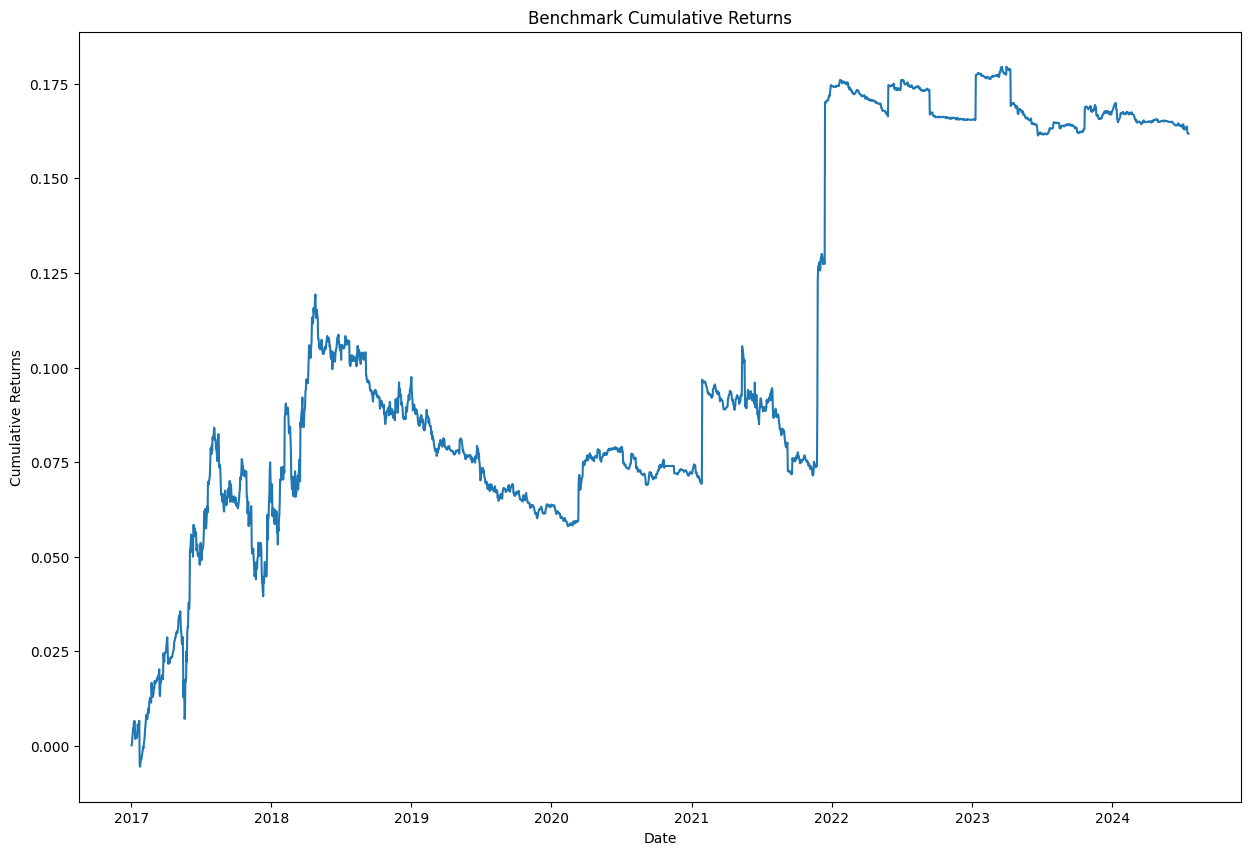

In [9]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 10))
plt.plot(df['date'], df['Bench_C_Rets'])
plt.title('Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

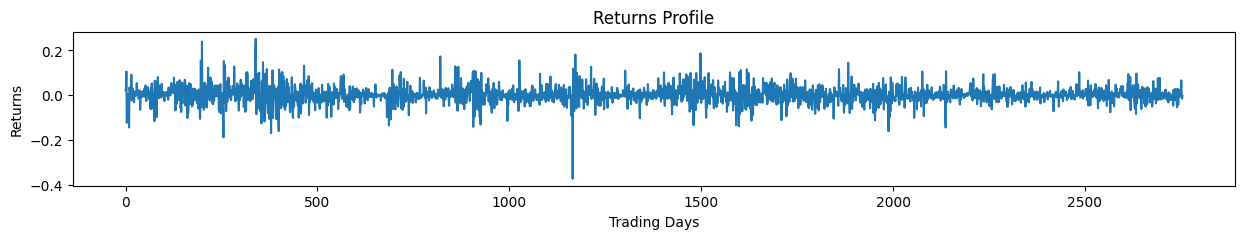

In [10]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df['returns'])
plt.title('Returns Profile')
plt.xlabel('Trading Days')
plt.ylabel('Returns')
plt.show()

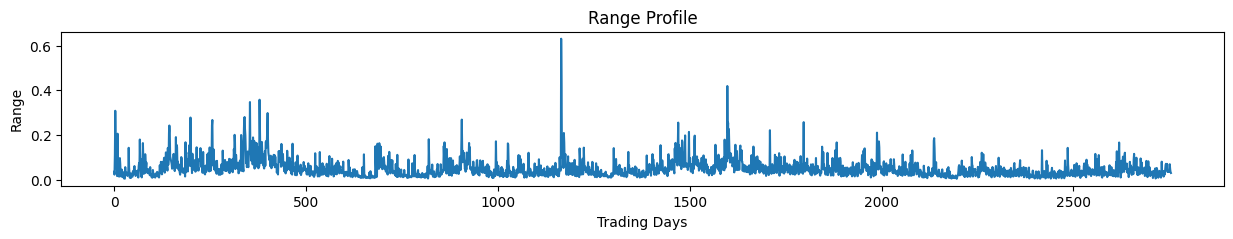

In [12]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df['range'])
plt.title('Range Profile')
plt.xlabel('Trading Days')
plt.ylabel('Range')
plt.show()

### Feature Engineering - Feature Expansion

In [16]:
# create a copy
df_fe = df.clone() # feature expansion copy
df_fe.head(3)

date,open,high,low,close,adj_close,volume,returns,range,Bench_C_Rets
datetime[ns],f64,f64,f64,f64,f64,i64,f64,f64,f64
2017-01-02 00:00:00,998.617004,1031.390015,996.702026,1021.75,1021.75,222184992,0.023464,0.034803,0.000146
2017-01-03 00:00:00,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,0.02162,0.022005,0.000682
2017-01-04 00:00:00,1044.400024,1159.420044,1044.400024,1154.72998,1154.72998,344945984,0.106233,0.11013,0.002415


##### Indicators